# AI Model for Physics Project
## Task 2

In this notebook you can find task 2 of the project.

- Costruire un dataset di grafi di spin glass a taglia e connettività fissati (# nodi non troppo alto). Studiare la comparazione tra l'apprendimento della magnetizzazione o dell'energia tra un MLP e una GNN.  Ovviamente in questo caso va ricavata la matrice di adiacenza e la matrice delle features a partire dai grafi per poter allenare l'MLP. (Livello medio)


Setting the GPU (it will work only with th fully connected network, GNNs not supported)

In [1]:
import torch
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import torch.nn.functional as F
import torchsummary
import os 
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import Linear
device = torch.device("mps:0") if torch.backends.mps.is_available() else torch.device("cpu")    # Check if GPU is available
print("Device:", device)    # Print the device

Device: mps:0




Creating the dataset as in task 1

In [2]:
# parameters for the dataset
n_nodes = 10
h = 0
n_samples = 5000

n_dimensions = 1
periodic = True


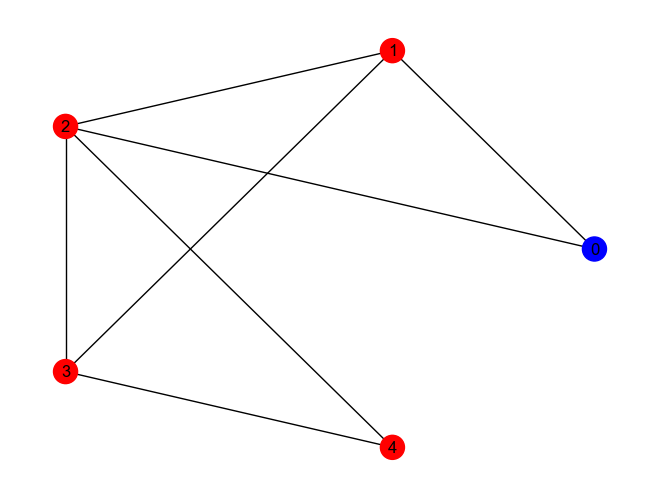

-0.14709817715370987
tensor(-0.1471)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.data import Data
import torch
from torch_geometric.utils import to_networkx, from_networkx

def initialize_graph(L, periodic=False, dimensions=2):
    """
    Initialize a graph with L nodes
    """
    G = nx.Graph()
    for i in range(L):
        G.add_node(i, spin=np.random.choice([-1, 1]))
        if periodic:
            for j in range(i + 1, i + dimensions + 1):
                G.add_edge(i, j % L, weight=np.random.rand() * 2 - 1)
        else:
            for j in range(i + 1, i + dimensions + 1):
                if j < L:
                    G.add_edge(i, j, weight=np.random.rand() * 2 - 1)
    return G

def plot_graph(G, pos=None):
    """
    Plot the graph with nodes colored according to their spin.
    """
    if pos is None:
        pos = nx.circular_layout(G)
    colors = ['blue' if G.nodes[i]["spin"] == 1 else 'red' for i in range(len(G.nodes))]
    nx.draw(G, pos=pos, node_color=colors, with_labels=True)
    plt.show()

L = 5
G = initialize_graph(L)
plot_graph(G)

def calculate_energy(G, h=0):
    """
    Calculate the energy of the graph
    """
    E = 0
    E_h = 0
    for i, j in G.edges:
        E += G[i][j]["weight"] * G.nodes[i]["spin"] * G.nodes[j]["spin"]

    if h != 0:  # exclude the case of h = 0 to avoid floating point errors
        E_h = h * np.sum([G.nodes[i]["spin"] for i in G.nodes])

    return -E / 2 - E_h  # divide by 2 to avoid double counting


print(calculate_energy(G))
print(torch.tensor(calculate_energy(G)).float())

## Creating the dataset
At first the comparison will be done for the energy

In [4]:
def create_dataset(L, num_samples, h=0, periodic=True, dimension=2):
    """
    Create a dataset of graphs with L nodes and num_samples samples
    """
    dataset = []
    graphs = []
    energies = []
    MLP_input = []
    for i in range(num_samples):
        G = initialize_graph(L, periodic, dimension)
        E = calculate_energy(G, h)
        A = nx.adjacency_matrix(G).todense()
        X = torch.tensor([G.nodes[i]["spin"] for i in G.nodes]).float().view(-1, 1)
        M = np.concatenate([X, A], axis=1)
        data = Data(x=X, edge_index=torch.tensor(np.array(G.edges)).T,
                    edge_weight=torch.tensor([G[i][j]["weight"] for i, j in G.edges]),
                    y=torch.tensor([E]).float())
        dataset.append(data)
        graphs.append(G)
        energies.append(data.y)
        MLP_input.append(M)

    return dataset, energies, graphs, MLP_input

In [43]:
trainset, energies, graphs, train_M  = create_dataset(10, 8000)
valset, val_energies, val_graphs, val_M = create_dataset(10, 2000)

## Implementing the MLP
Input needs to be flattened to be used in the MLP

In [44]:
# Flatten the input for the MLP by concatenating the columns
train_M = [torch.tensor(np.array(m).flatten()).float() for m in train_M]
val_M = [torch.tensor(np.array(m).flatten()).float() for m in val_M]

target_train = [e for e in energies]
target_val = [e for e in val_energies]


#Print the first input of the MLP
print(train_M[0])
print(target_train[0])

print(train_M[0].shape)

tensor([ 1.0000,  0.0000, -0.5274,  0.9368,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.2848,  0.5784, -1.0000, -0.5274,  0.0000,  0.9542,  0.4873,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.7751, -1.0000,  0.9368,
         0.9542,  0.0000, -0.9250,  0.7539,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  1.0000,  0.0000,  0.4873, -0.9250,  0.0000, -0.9392, -0.8072,
         0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.7539,
        -0.9392,  0.0000, -0.0996, -0.2309,  0.0000,  0.0000,  0.0000, -1.0000,
         0.0000,  0.0000,  0.0000, -0.8072, -0.0996,  0.0000,  0.6621,  0.7302,
         0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.2309,
         0.6621,  0.0000,  0.1451, -0.7126,  0.0000, -1.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.7302,  0.1451,  0.0000, -0.1254,  0.0175,
        -1.0000,  0.2848,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.7126,
        -0.1254,  0.0000, -0.5831,  1.00

In [53]:
# Creating the dataloaders
from torch.utils.data import DataLoader, TensorDataset  #Using standard PyTorch DataLoader and not the one from torch_geometric
train_loader = DataLoader(TensorDataset(torch.stack(train_M), torch.stack(target_train)), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.stack(val_M), torch.stack(target_val)), batch_size=1, shuffle=False)

## Defining the MLP
It is a simple feedforward network with 3 layers, with number of parameters similar to the GNN

In [46]:
# Defining the MLP
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = Linear(110, 64)
        self.fc2 = Linear(64, 32)
        self.fc3 = Linear(32, 1)
        
        #Criterion
        self.criterion = torch.nn.MSELoss()
        
        #Optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def train_step(self, x, y):
        self.optimizer.zero_grad()
        output = self(x)
        loss = self.criterion(output, y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

In [9]:
#summary of the model
model = MLP()
torchsummary.summary(model, (110,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           7,104
            Linear-2                   [-1, 32]           2,080
            Linear-3                    [-1, 1]              33
Total params: 9,217
Trainable params: 9,217
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [47]:
# Initialize the model to the device
model = MLP()
model.to(device)

MLP(
  (fc1): Linear(in_features=110, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (criterion): MSELoss()
)

In [48]:
# Training the model
n_epochs = 50
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    epoch_loss =  []
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        loss = model.train_step(x, y)
        epoch_loss.append(loss)
    train_losses.append(np.mean(epoch_loss))
    

    model.eval()
    epoch_val = []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = model.criterion(output, y)
            epoch_val.append(loss.item())
    val_losses.append(np.mean(epoch_val))
    print(f"Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}")

Epoch 1/50, Train Loss: 1.6384078879356385, Val Loss: 1.6832961392781092
Epoch 2/50, Train Loss: 1.6202773656845093, Val Loss: 1.6715030291723827
Epoch 3/50, Train Loss: 1.5852489650249482, Val Loss: 1.6372690777930001
Epoch 4/50, Train Loss: 1.5176044776439668, Val Loss: 1.5966255863507588
Epoch 5/50, Train Loss: 1.406197735309601, Val Loss: 1.5226901816943335
Epoch 6/50, Train Loss: 1.2841853730678559, Val Loss: 1.4639691142808824
Epoch 7/50, Train Loss: 1.1605408070087433, Val Loss: 1.4008971093192932
Epoch 8/50, Train Loss: 1.0583062224388122, Val Loss: 1.3199842846582805
Epoch 9/50, Train Loss: 0.9618780487775802, Val Loss: 1.283093153484284
Epoch 10/50, Train Loss: 0.8852792106866837, Val Loss: 1.2574787016898867
Epoch 11/50, Train Loss: 0.821372125864029, Val Loss: 1.2093495641435896
Epoch 12/50, Train Loss: 0.7623889911174774, Val Loss: 1.1930043299992878
Epoch 13/50, Train Loss: 0.7200597674846649, Val Loss: 1.1381050632113503
Epoch 14/50, Train Loss: 0.6777440425157547, Val L

Text(0.5, 1.0, 'Losses')

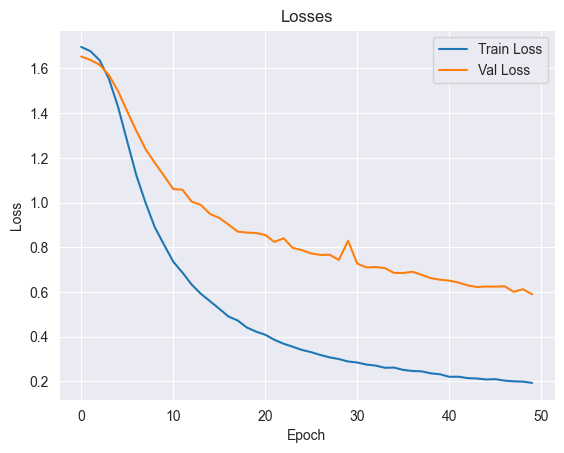

In [12]:
# Plot the losses
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Losses")

In [13]:
# GNN model for the same task, it has less parameters than in task 1 in order to be comparable with the MLP
import torch
import torch.nn.functional as F
from torch_geometric.nn import GraphConv, global_max_pool
from torch_geometric.data import Data


class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GraphConv(1, 16)
        self.conv2 = GraphConv(16, 32)
        self.conv3 = GraphConv(32, 64)
        self.conv4 = GraphConv(64, 32)
        self.conv5 = GraphConv(32, 16)
        self.fc1 = torch.nn.Linear(16, 8)
        self.fc2 = torch.nn.Linear(8, 1)
        self.dropout = torch.nn.Dropout(0.4)
        #Criterion
        self.criterion = torch.nn.MSELoss()

        #Optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0005)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        batch_index = data.batch
        x = F.leaky_relu(self.conv1(x, edge_index, edge_weight))
        x = F.leaky_relu(self.conv2(x, edge_index, edge_weight))
        x = F.leaky_relu(self.conv3(x, edge_index, edge_weight))
        x = F.leaky_relu(self.conv4(x, edge_index, edge_weight))
        x = F.leaky_relu(self.conv5(x, edge_index, edge_weight))
        x = global_max_pool(x, batch_index)
        #Flatten the tensor
        x = x.view(-1, 16)
        #print(x.shape)
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def train_step(self, data):
        self.optimizer.zero_grad()
        out = self.forward(data)
        loss = self.criterion(out, data.y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

In [14]:
#Summary, the number of parameters is similar to the MLP
summarygnn = GNN()
#summary
sum(p.numel() for p in summarygnn.parameters())


10577

In [49]:
#Training the GNN
from torch_geometric.data import DataLoader #Using DataLoader from torch_geometric

trainloader = DataLoader(trainset, batch_size=1, shuffle=True)
valloader = DataLoader(valset, batch_size=1, shuffle=False)

gnn = GNN()

train_plot = []
val_plot = []
best_loss = 100
for epoch in (range(50)):
    #Training
    gnn.train()
    losses = []
    for data in (trainloader):
        data = data
        loss = gnn.train_step(data)
        losses.append(loss)
    print("Epoch ", epoch, "Training Loss: ", sum(losses) / len(losses))
    train_plot.append(sum(losses) / len(losses))

    #Validation
    gnn.eval()
    val_losses_GNN = []
    for data in valloader:
        val_losses_GNN.append(gnn.criterion(gnn.forward(data), data.y).item())
    if sum(val_losses_GNN) / len(val_losses_GNN) < best_loss:
        best_loss = sum(val_losses_GNN) / len(val_losses_GNN)
        torch.save(gnn.state_dict(), "best_model_energy.pth")

    print("Epoch ", epoch, "Validation loss: ", sum(val_losses_GNN) / len(val_losses_GNN))
    val_plot.append(sum(val_losses_GNN) / len(val_losses_GNN))
    

/opt/anaconda3/envs/pythonProject/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/opt/anaconda3/envs/pythonProject/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  0 Training Loss:  0.6558804029782349
Epoch  0 Validation loss:  0.27870796746220267
Epoch  1 Training Loss:  0.46416755258590325
Epoch  1 Validation loss:  0.2289900891180153
Epoch  2 Training Loss:  0.42049298302483856
Epoch  2 Validation loss:  0.23420496491386597
Epoch  3 Training Loss:  0.4330022406572664
Epoch  3 Validation loss:  0.2086505369579356
Epoch  4 Training Loss:  0.4110848320219142
Epoch  4 Validation loss:  0.29552458473169524
Epoch  5 Training Loss:  0.4070148021332492
Epoch  5 Validation loss:  0.24223920659647993
Epoch  6 Training Loss:  0.40852391941719035
Epoch  6 Validation loss:  0.2031153543881414
Epoch  7 Training Loss:  0.3978682886974895
Epoch  7 Validation loss:  0.20589153552538952
Epoch  8 Training Loss:  0.3834344980998846
Epoch  8 Validation loss:  0.21561949878500358
Epoch  9 Training Loss:  0.3772887586312224
Epoch  9 Validation loss:  0.19041549646382291
Epoch  10 Training Loss:  0.379369622330994
Epoch  10 Validation loss:  0.1894872583221052

Text(0.5, 1.0, 'Losses')

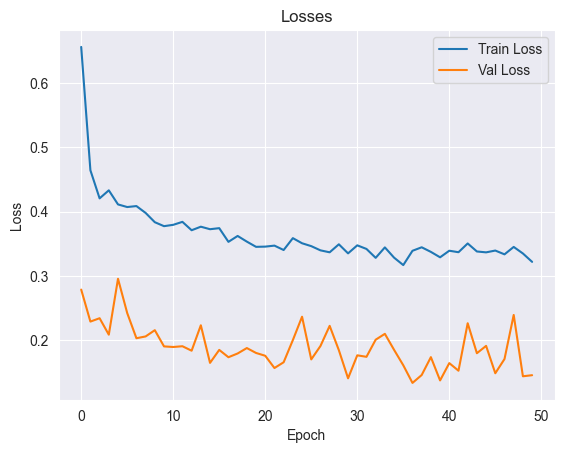

In [50]:
#Plotting the losses
plt.plot(train_plot, label="Train Loss")
plt.plot(val_plot, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Losses")

In [17]:
#Comparison
#validation loss for the GNN
print("Best validation loss for GNN:", best_loss)
#validation loss for the MLP
print("Best validation loss for MLP:", min(val_losses))

Best validation loss for GNN: 0.13316670402969027
Best validation loss for MLP: 0.5897491479676867


Text(0.5, 1.0, 'GNN Predictions vs True Values, Energy')

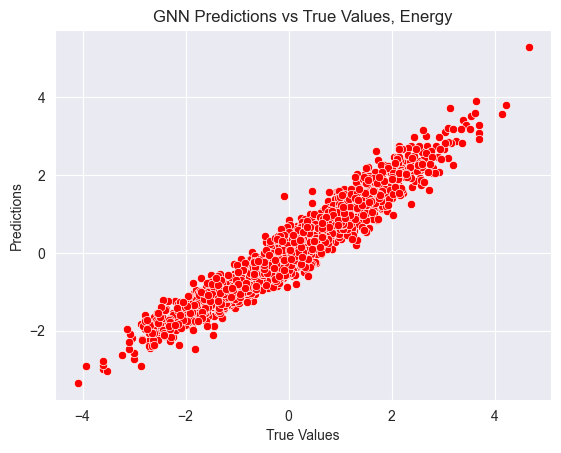

In [51]:
import seaborn as sns
#plot the predictions on the validation set for the GNN compared to the true values
gnn = GNN()
gnn.load_state_dict(torch.load("best_model_energy.pth"))
gnn.eval()
predictions = []
true_values = []
for data in valloader:
    predictions.append(gnn.forward(data).item())
    true_values.append(data.y.item())

sns.scatterplot( x = true_values, y = predictions, color = "red")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("GNN Predictions vs True Values, Energy")


Text(0.5, 1.0, 'MLP Predictions vs True Values, Energy')

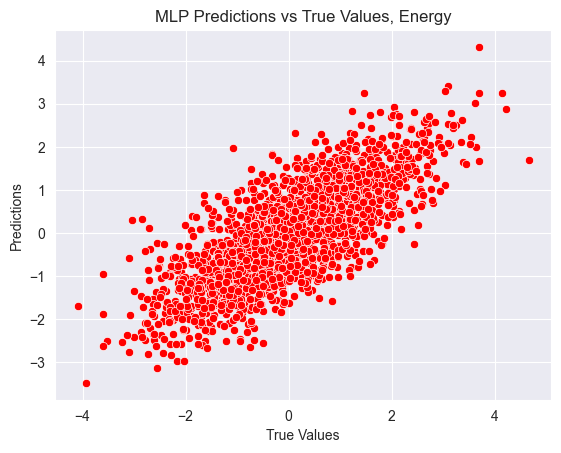

In [54]:
#plot the predictions on the validation set for the MLP compared to the true values

predictions = []
true_values = []
for data in val_loader:
    x, y = data
    x = x.to(device)
    output = model(x)
    predictions.append(output.item())
    true_values.append(y.item())
    
sns.scatterplot( x = true_values, y = predictions, color = "red")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("MLP Predictions vs True Values, Energy")

# Magnetization
After the comparison for energy, we can repeat the same for magnetization


In [18]:
# Creating a dataset with magnetization as target
def create_dataset_magnetization(L, num_samples, h=0, periodic=True, dimension=2):
    """
    Create a dataset of graphs with L nodes and num_samples samples
    """
    dataset = []
    graphs = []
    magnetizations = []
    MLP_input = []
    for i in range(num_samples):
        G = initialize_graph(L, periodic, dimension)
        M = np.sum([G.nodes[i]["spin"] for i in G.nodes])
        A = nx.adjacency_matrix(G).todense()
        X = torch.tensor([G.nodes[i]["spin"] for i in G.nodes]).float().view(-1, 1)
        MLP = np.concatenate([X, A], axis=1)
        data = Data(x=X, edge_index=torch.tensor(np.array(G.edges)).T,
                    edge_weight=torch.tensor([G[i][j]["weight"] for i, j in G.edges]),
                    y=torch.tensor([M]).float())
        dataset.append(data)
        graphs.append(G)
        magnetizations.append(data.y)
        MLP_input.append(MLP)

    return dataset, magnetizations, graphs, MLP_input

In [19]:
trainset, magnetizations, graphs, train_M = create_dataset_magnetization(10, 8000)
valset, val_magnetizations, val_graphs, val_M = create_dataset_magnetization(10, 2000)

In [20]:
# Flatten the input for the MLP by concatenating the columns
train_M = [torch.tensor(np.array(m).flatten()).float() for m in train_M]
val_M = [torch.tensor(np.array(m).flatten()).float() for m in val_M]


In [37]:
from torch.utils.data import DataLoader, TensorDataset  #Using standard PyTorch DataLoader and not the one from torch_geometric
train_loader = DataLoader(TensorDataset(torch.stack(train_M), torch.stack(magnetizations)), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.stack(val_M), torch.stack(val_magnetizations)), batch_size=1, shuffle=False)

In [38]:
#Training the MLP
model = MLP()

model.to(device)
n_epochs = 10
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    epoch_loss =  []
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        loss = model.train_step(x, y)
        epoch_loss.append(loss)
    train_losses.append(np.mean(epoch_loss))
    

    model.eval()
    epoch_val = []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = model.criterion(output, y)
            epoch_val.append(loss.item())
    val_losses.append(np.mean(epoch_val))
    print(f"Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}")

Epoch 1/10, Train Loss: 2.146910880248958, Val Loss: 0.024203811269750988
Epoch 2/10, Train Loss: 0.017857801200399478, Val Loss: 0.012430878262242475
Epoch 3/10, Train Loss: 0.008195802820816684, Val Loss: 0.006299865336684852
Epoch 4/10, Train Loss: 0.004753015715236101, Val Loss: 0.0046939118287901704
Epoch 5/10, Train Loss: 0.003545307829535712, Val Loss: 0.0043202089818600835
Epoch 6/10, Train Loss: 0.0028710428183859648, Val Loss: 0.0031251112211501245
Epoch 7/10, Train Loss: 0.0023039291057134637, Val Loss: 0.0027210342943214194
Epoch 8/10, Train Loss: 0.0018700637211933875, Val Loss: 0.0021813672325166314
Epoch 9/10, Train Loss: 0.0015618051883925241, Val Loss: 0.0015739276926198364
Epoch 10/10, Train Loss: 0.00129396121591157, Val Loss: 0.0014069979820398508


Text(0.5, 1.0, 'Losses')

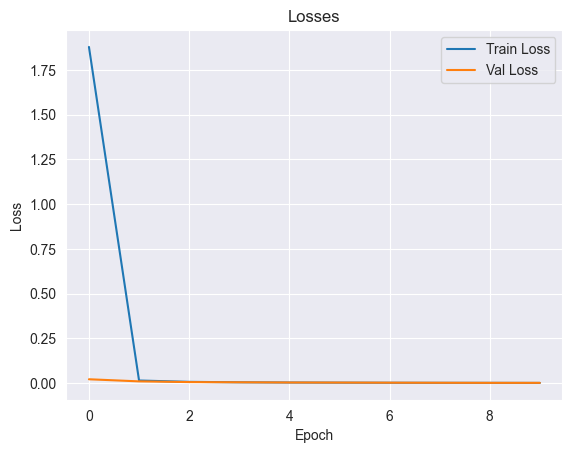

In [23]:
# Plot the losses
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Losses")

In [24]:
#Training the GNN on the magnetization
#using torch geometric Dataloader
from torch_geometric.data import DataLoader
trainloader = DataLoader(trainset, batch_size=1, shuffle=True)
valloader = DataLoader(valset, batch_size=1, shuffle=False)

gnn = GNN()

train_plot = []
val_plot = []
best_loss = 100

for epoch in (range(10)):
    #Training
    gnn.train()
    losses = []
    for data in (trainloader):
        loss = gnn.train_step(data)
        losses.append(loss)
    print("Epoch ", epoch, "Training Loss: ", sum(losses) / len(losses))
    train_plot.append(sum(losses) / len(losses))

    #Validation
    gnn.eval()
    val_losses_GNN = []
    for data in valloader:
        val_losses_GNN.append(gnn.criterion(gnn.forward(data), data.y).item())
    if sum(val_losses_GNN) / len(val_losses_GNN) < best_loss:
        best_loss = sum(val_losses_GNN) / len(val_losses_GNN)
        torch.save(gnn.state_dict(), "best_model.pth")

    print("Epoch ", epoch, "Validation loss: ", sum(val_losses_GNN) / len(val_losses_GNN))
    val_plot.append(sum(val_losses_GNN) / len(val_losses_GNN))

Epoch  0 Training Loss:  4.513597635480267
Epoch  0 Validation loss:  2.4394069580262974
Epoch  1 Training Loss:  3.268285015338831
Epoch  1 Validation loss:  1.808682552835373
Epoch  2 Training Loss:  2.8340850290658213
Epoch  2 Validation loss:  1.7412892962035562
Epoch  3 Training Loss:  2.8200664855450914
Epoch  3 Validation loss:  1.8163056306504448
Epoch  4 Training Loss:  2.6175018053941357
Epoch  4 Validation loss:  1.54735109452968
Epoch  5 Training Loss:  2.502497073951615
Epoch  5 Validation loss:  1.915766191872029
Epoch  6 Training Loss:  2.4741926476938096
Epoch  6 Validation loss:  1.4651902241970705
Epoch  7 Training Loss:  2.5247465608966384
Epoch  7 Validation loss:  1.2484185261387544
Epoch  8 Training Loss:  2.4665747044979276
Epoch  8 Validation loss:  1.2358547967298905
Epoch  9 Training Loss:  2.5040413801796078
Epoch  9 Validation loss:  1.2121855548241245


Text(0.5, 1.0, 'Losses')

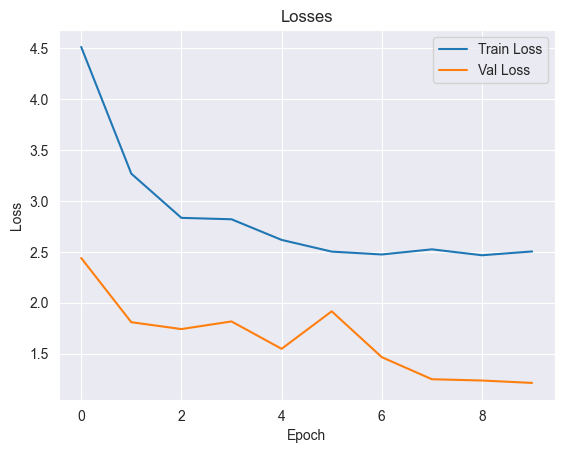

In [25]:
#Plot the losses
plt.plot(train_plot, label="Train Loss")
plt.plot(val_plot, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Losses")

In [26]:
#Comparison
#validation loss for the GNN
print("Best validation loss for GNN:", best_loss)
#validation loss for the MLP
print("Best validation loss for MLP:", min(val_losses))


Best validation loss for GNN: 1.2121855548241245
Best validation loss for MLP: 0.0017920212772904924


Text(0.5, 1.0, 'GNN Predictions vs True Values, Magnetization')

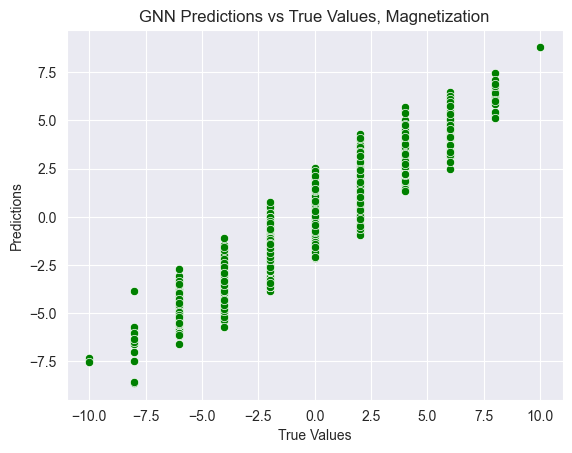

In [32]:
import seaborn as sns
#plot the predictions on the validation set for the GNN compared to the true values
gnn = GNN()
gnn.load_state_dict(torch.load("best_model.pth"))
gnn.eval()
predictions = []
true_values = []
for data in valloader:
    predictions.append(gnn.forward(data).item())
    true_values.append(data.y.item())
    
sns.scatterplot( x = true_values, y = predictions, color = "green")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("GNN Predictions vs True Values, Magnetization")


Text(0.5, 1.0, 'MLP Predictions vs True Values, Magnetization')

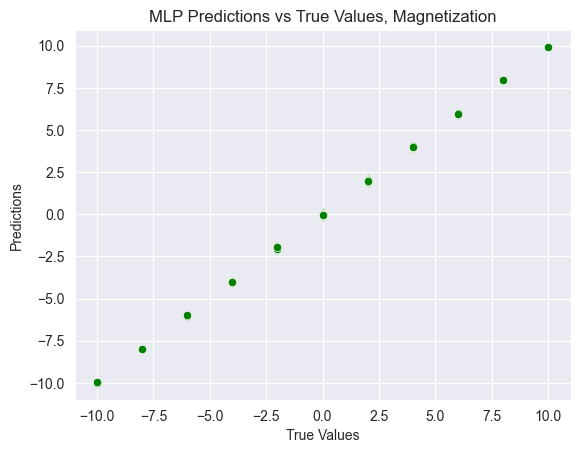

In [42]:
#plot the predictions on the validation set for the MLP compared to the true values
from torch.utils.data import DataLoader, TensorDataset  #Using standard PyTorch DataLoader and not the one from torch_geometric
predictions = []
true_values = []
for data in val_loader:
    x, y = data
    x = x.to(device)
    output = model(x)
    predictions.append(output.item())
    true_values.append(y.item())

sns.scatterplot( x = true_values, y = predictions, color = "green")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("MLP Predictions vs True Values, Magnetization")
